# 2.3 Build the Heterogeneous Ethereum Graph  
(EOA ↔ Contract ↔ Token Multi-Type Network)

In this notebook, we build a **heterogeneous graph** where:

- Node types:
  1. EOA (users, bots, exchanges)
  2. Smart Contracts
  3. Token Contracts (ERC20)
- Edge types:
  1. ETH Transfer (EOA → EOA / Contract)
  2. Token Transfer (EOA → TokenContract)
  3. Contract Creation (EOA → Contract)
  4. Contract Invocation (EOA → Contract)

This creates a multi-relational graph that reflects the real structure of Ethereum.

## 1. Imports + Load Data


In [49]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pickle
from pathlib import Path

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)
from src.data.load_data import (
    load_raw_contracts,
    load_clean_transactions,
    load_clean_token_transfers
)


plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = True

tx = load_clean_transactions()
token_tx = load_clean_token_transfers()

contracts = load_raw_contracts()  # raw lookup table
contracts.head()


,address,is_erc20,is_erc721,block_number,bytecode_json,function_sighashes_json
0,0x4ab476a886578b415408b2a28ceeb04e86a2a39e,False,False,23688468,"""0x""",[]
1,0xf71fbb7e023522739e536217c3c411d9fe0c6ca7,False,False,23718672,"""0x""",[]
2,0x4ab476a886578b415408b2a28ceeb04e86a2a39e,False,False,23775607,"""0x""",[]
3,0x023637d49f961bf91c7aebb75d453d1f8f9e2c27,False,False,23773261,"""0x""",[]
4,0xf71fbb7e023522739e536217c3c411d9fe0c6ca7,False,False,23568673,"""0x""",[]


## 2. Define Heterogeneous Graph

In [3]:
G = nx.MultiDiGraph()

## 3. Add Node Types

In [9]:
contract_set = set(contracts["address"].str.lower())
print(f"Number of contract addresses: {len(contract_set)}")

all_addrs = set(tx["from_address"]).union(set(tx["to_address"]))
EOA_set = all_addrs - contract_set
print(f"Number of EOA addresses: {len(EOA_set)}")

# Add EOA nodes
for addr in EOA_set:
    G.add_node(addr, node_type="EOA")

# Add Contract nodes
for addr in contract_set:
    G.add_node(addr, node_type="Contract")
print(f"Total number of nodes in the graph: {G.number_of_nodes()}")


Number of contract addresses: 2826
Number of EOA addresses: 7440
Total number of nodes in the graph: 10266


## 3.2 Add Token Contract Nodes

In [11]:
token_contracts = set(token_tx["token_address"])
for tk in token_contracts:
    G.add_node(tk, node_type="TokenContract")
print(f"Total number of nodes in the graph after adding Token Contracts: {G.number_of_nodes()}")


Total number of nodes in the graph after adding Token Contracts: 10268


## 4. Add Edge Types
setup mutiple edge types

## 4.1 ETH Transfer edges

In [13]:
for _, row in tx.iterrows():
    G.add_edge(
        row["from_address"], 
        row["to_address"],
        key="eth_transfer",
        edge_type="ETH_TRANSFER",
        value=row["value"],
        timestamp=row["block_timestamp"]
    )
print(f"Total number of edges in the graph after adding ETH transfers: {G.number_of_edges()}")


Total number of edges in the graph after adding ETH transfers: 9220


## 4.2 Token Transfer edges

In [20]:
for _, row in token_tx.iterrows():
    G.add_edge(
        row["from_address"], 
        row["token_address"],
        key="token_transfer",
        edge_type="TOKEN_TRANSFER",
        raw_value=row["raw_value"],
        timestamp=row["block_timestamp"]
    )
print(f"Total number of edges in the graph after adding Token transfers: {G.number_of_edges()}")


Total number of edges in the graph after adding Token transfers: 30638


## 4.3 Contract Creation edges

In [33]:
if "creator_address" in contracts.columns:
    for _, row in contracts.iterrows():
        G.add_edge(
            row["creator_address"],
            row["contract_address"],
            key="contract_creation",
            edge_type="CREATE_CONTRACT"
        )
print(f"Total number of edges in the graph after adding Contract Creations: {G.number_of_edges()}")


Total number of edges in the graph after adding Contract Creations: 30638


## 5. Graph Summary

In [22]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Nodes:", num_nodes)
print("Edges:", num_edges)


Nodes: 26447
Edges: 30638


## 6. Node Type Stats

In [31]:
# in case some nodes are missing node_type
contract_set_l = set(a.lower() for a in contract_set)
token_set_l = set(a.lower() for a in token_contracts)

missing = [n for n, d in G.nodes(data=True) if 'node_type' not in d]
print(f"Nodes missing node_type: {len(missing)} (: {missing[:10]})")

for n in missing:
    key = n.lower() if isinstance(n, str) else n
    if key in token_set_l:
        G.nodes[n]['node_type'] = 'TokenContract'
    elif key in contract_set_l:
        G.nodes[n]['node_type'] = 'Contract'
    else:
        G.nodes[n]['node_type'] = 'EOA'

node_types = {}

for n, d in G.nodes(data=True):
    t = d["node_type"]
    node_types[t] = node_types.get(t, 0) + 1

node_types


Nodes missing node_type: 0 (示例: [])


{'EOA': 23619, 'Contract': 2825, 'TokenContract': 3}

Here, 
EOA is Externally Owned Account (user, bot, exchange).
Contract is Smart Contract.
TokenContract is ERC20 Token Contract.

Apparently, EOA has a majority among all node types. Contracts are also significant, while TokenContracts are relatively few. This is expected in really, 

## 7. Edge Type Stats

In [34]:
edge_types = {}
for _, _, d in G.edges(data=True):
    t = d["edge_type"]
    edge_types[t] = edge_types.get(t, 0) + 1

edge_types


{'ETH_TRANSFER': 9220, 'TOKEN_TRANSFER': 21418}

## 8. Visualize a small ego graph

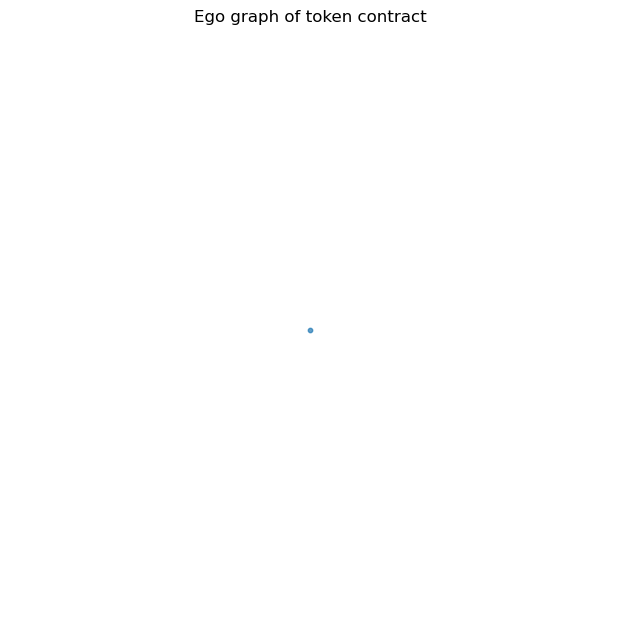

In [46]:
target = list(token_contracts)[0]

G_sub = nx.ego_graph(G, target, radius=2, distance='weight')

plt.figure(figsize=(6,6))
nx.draw_spring(G_sub, node_size=10, alpha=0.7)
plt.title("Ego graph of token contract")
plt.show()


In [50]:
out = Path(PROJECT_ROOT) / "data" / "processed" / "heterogeneous_graph.gpickle"
out.parent.mkdir(parents=True, exist_ok=True)
with out.open("wb") as f:
    pickle.dump(G, f)


# Why Heterogeneous Ethereum Graph?

Ethereum is not a simple "address-to-address" network.

It contains:
- users (EOA)
- token contracts
- smart contracts
- DEX pools
- bridges
- routers
- MEV searchers

A heterogeneous graph:
- preserves the real structure,
- captures different interaction modes,
- supports path tracing,
- reveals MEV routes,
- detects fraudulent token patterns,
- supports community detection across token ecosystems.

This is the foundation for:
- Whale behavior analysis (Module 3)
- MEV bot detection (Module 4)
- Token ecosystem clustering
- Transaction path tracing
